In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy import signal

### 1. OTDR model 

In [2]:
class otdr():
    
    def __init__(self):
        self.alpha = 0.0410517 * 1e-3 # attenuation, 1/m
        self.c = 300000000 # light speed, m/s
        self.n0 = 1.5      # refractive index
        lamda = 1550e-9 # wavelength, m
        kv = 2*np.pi/lamda # wavenumber, 1/m  
        self.w0 = kv * self.c / self.n0 # carrier frequency, rad/s
    
    def set_params(self, params):
        """
        setting parameters of 
        fiber: L - fiber length in m, n_rc - number of RC per meter in 1/m;
        receiver: Ladc - sampling frequency of receiver in m, T - time of capturing data in s;
        pulse: tau - pulse duration in s, fp - probing frequency in Hz, w_drift - linear carrier frequency drift in Hz/s;
        PZT: K_mod - coefficient in rad, F_mod - frequency modualtion in Hz, Z_pzt - PZT position in m, len_pzt - PZT length.
        """
        
        """set_fiber"""
        L = params['fiber']['L']
        n_rc = params['fiber']['n_rc']
        np.random.seed(1) # fixing random RC distribution
        self.z_rc = np.sort(np.random.rand(int(n_rc*L)))*L # RC's coordinates along fiber
        
        """set_receiver"""
        Ladc = params['receiver']['Ladc']
        long_time = params['receiver']['long_time']
        self.Ndots = int(L / Ladc) 
        time_back = 2 * L * self.n0 / self.c  # duration of backscattering signal, s
        fast_time = np.linspace(0, time_back, self.Ndots) # time-window of backscattered signal, s
        self.Distance = fast_time * self.c / self.n0 / 2 # spatial-window of backscattered signal, s
        
        """set_pulse"""
        self.w_drift = params['pulse']['w_drift']
        tau = params['pulse']['tau']
        fp = params['pulse']['fp']
        self.Time = np.arange(0, long_time, 1/fp)

        self.Timp = fast_time[fast_time <= tau]  # time-window of probe pulse, s
        self.Pulse = np.heaviside(tau/2 - np.abs(self.Timp-tau/2),1) # probe pulse  
        self.NPulse=len(self.Timp)
        
        self.ZN = np.array(self.z_rc / L * (self.Ndots - self.NPulse), dtype=np.int) # it z-coordinate index in spatial-window "Distance" OTDR-trace
        
        """set_PZT"""
        self.K_mod = params['PZT']['K_mod']
        self.F_mod = params['PZT']['F_mod']
        self.Z_pzt = params['PZT']['Z_pzt']
        self.len_pzt = params['PZT']['len_pzt']
        
    
    def PZT(self, t):
        
        return self.K_mod * np.sin(2 * np.pi * self.F_mod * t)
        
    def get_amp(self, t):
        
        w = self.w0 + 2 * np.pi * self.w_drift * t
        kv = w * self.n0 / self.c
        A = np.zeros(self.Ndots, dtype='complex64') #A(z) backscattering signal (complex amplitude) at reciver (z=0, t=n*2*z_k/c)
        phase_pzt = 0
        
        for z_n, Zn in zip(self.z_rc, self.ZN):
            
            if z_n >= self.Z_pzt and z_n < self.Z_pzt + self.len_pzt:
                
                phase_pzt = (z_n - self.Z_pzt) / self.len_pzt *  self.PZT(t)
                
                
            pulse_back = self.Pulse * np.exp(2j * (kv * z_n + phase_pzt)) # backscattered pulse at receiver (z=0)
            
            if Zn < 0: 
                
                A[0:Zn+self.NPulse] += pulse_back[:Zn+self.NPulse]

            elif Zn >= 0: # in case when part pulse behind of spatial-window
                
                A[Zn:Zn+self.NPulse] += pulse_back[:]

            else: # in case when part pulse beyound of spatial-window
                
                A[Zn:self.Ndots] += pulse_back[:self.Ndots - Zn]
                
                
        return A
    
    def get_waterfall(self, params):
        
        self.set_params(params)
        W = [self.get_amp(t) for t in self.Time]
        
        return W, self.Time, self.Distance, params

### 2. OTDR-trace decorrelation due carrier frequancy drift

#### setting parametrs of OTDR and fiber line: with laser carrier frequency drift (PZT is off)

In [3]:
params = {
    'fiber': {'L': 1000, 'n_rc': 3},
    'receiver': {'Ladc': 1, 'long_time': 1},
    'pulse': {'tau': 200e-9, 'fp': 1e3, 'w_drift': 6e6},
    'PZT': {'K_mod': 0, 'F_mod': 0, 'Z_pzt': 500, 'len_pzt': 30}
}

In [4]:
OTDR = otdr()

In [5]:
W, T, D, inparams = OTDR.get_waterfall(params)

Text(0, 0.5, 'Power, o.e.')

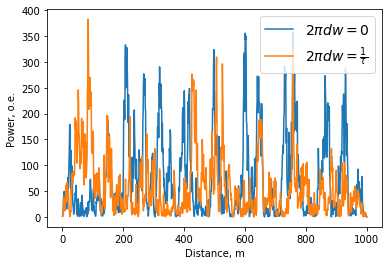

In [6]:
plt.plot(D, np.abs(W)[0]**2, label='$2\pi dw = 0$')
plt.plot(D, np.abs(W)[-1]**2, label=r'$2\pi dw = \frac{1}{\tau}$')

plt.legend(fontsize=14)
plt.xlabel('Distance, m')
plt.ylabel('Power, o.e.')

###  According to [article](https://opg.optica.org/ol/abstract.cfm?uri=ol-26-2-58) decorrelation of OTDR-traces due carrier frequancy drift can be described by the function:
$$sinc(x)^2=\frac{sin(x)^2}{x^2}$$
### where x is $\pi\tau\Delta\nu$

In [7]:
C = [np.corrcoef(np.abs(W[0])**2, i)[0][1]*100 for i in np.abs(W)**2]
dnyu = inparams['pulse']['w_drift'] * T / 1e6

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


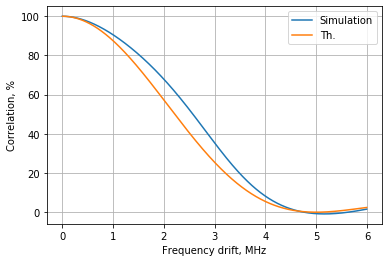

In [8]:
plt.plot(dnyu, C, label='Simulation')

x = np.pi*inparams['pulse']['tau']*dnyu*1e6

plt.plot(dnyu, (np.sin(x)/x)**2*100, label='Th.')


plt.ylabel('Correlation, %')
plt.xlabel('Frequency drift, MHz')
plt.legend()
plt.grid()

Text(0.5, 1.0, 'OTDR decorrelation waterfall over time due frequency drift')

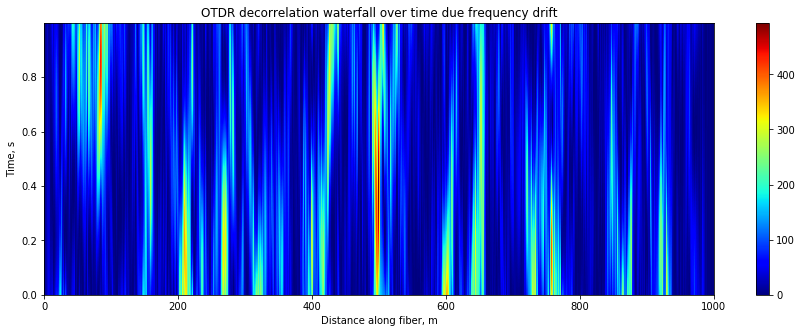

In [9]:
plt.figure(figsize=(15,5))
plt.imshow(np.abs(W)**2, aspect='auto', origin='bottom', extent=[0, np.max(D), 0, np.max(T)], cmap='jet')
plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Time, s')
plt.title('OTDR decorrelation waterfall over time due frequency drift')

### 3. setting parametrs of OTDR and fiber line: with minor  laser carrier frequency drift (PZT is on)

In [10]:
params_pzt = {
    'fiber': {'L': 1000, 'n_rc': 3},
    'receiver': {'Ladc': 1, 'long_time': 1},
    'pulse': {'tau': 200e-9, 'fp': 1e3, 'w_drift': 1e3},
    'PZT': {'K_mod': 1, 'F_mod': 10, 'Z_pzt': 500, 'len_pzt': 30}
}

In [11]:
W_pzt, T_pzt, D_pzt, inparams_pzt = OTDR.get_waterfall(params_pzt)

#### 3.1. Intensity changes

Text(0.5, 1.0, 'OTDR difference waterfall with pzt inline')

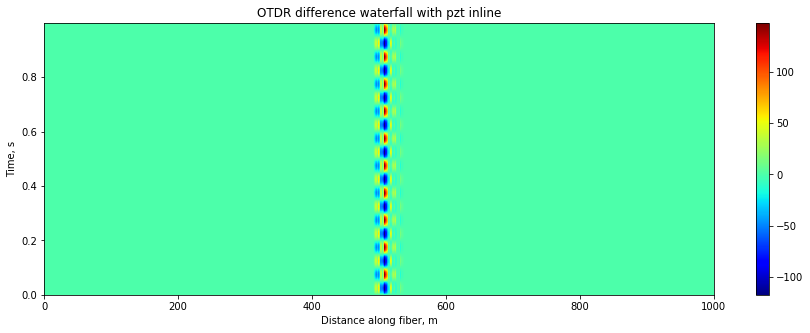

In [12]:
plt.figure(figsize=(15,5))
plt.imshow(np.abs(W_pzt)**2-np.abs(W_pzt[0])**2, aspect='auto', 
           origin='bottom', extent=[0, np.max(D_pzt), 0, np.max(T_pzt)], cmap='jet')
plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Time, s')
plt.title('OTDR difference waterfall with pzt inline')

Text(0, 0.5, 'Intensity, o.e.')

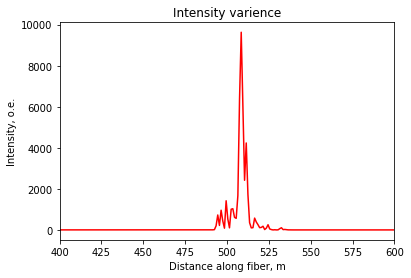

In [13]:
plt.title('Intensity varience')
plt.plot(D_pzt, np.std(np.abs(W_pzt)**2-np.abs(W_pzt[0])**2, axis=0)**2 , c='red')
plt.xlim(400,600)
plt.xlabel('Distance along fiber, m')
plt.ylabel('Intensity, o.e.')

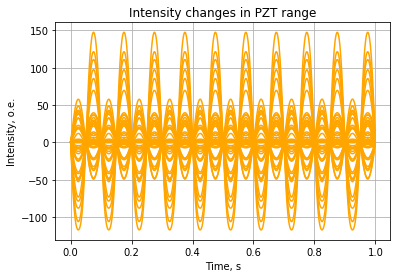

In [14]:
plt.title('Intensity changes in PZT range')
plt.plot(T_pzt, (np.abs(W_pzt)**2-np.abs(W_pzt[0])**2)[:,480:530], c='orange')
plt.xlabel('Time, s')
plt.ylabel('Intensity, o.e.')
plt.grid()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


(0, 120)

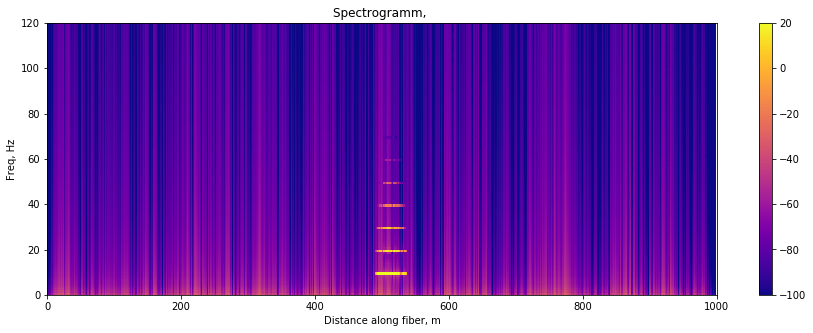

In [15]:
freq, Pxx = signal.periodogram(np.abs(W_pzt)**2-np.abs(W_pzt[0])**2, fs=1/(T_pzt[1]-T_pzt[0]), axis=0)

plt.figure(figsize=(15,5))
plt.imshow(10*np.log10(Pxx[1:]), aspect='auto', origin='bottom', 
           extent=[0, np.max(D_pzt), 0, np.max(freq)], cmap='plasma', vmin=-100, vmax=20)

plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Freq, Hz')
plt.title('Spectrogramm, ')
plt.ylim(0,120)

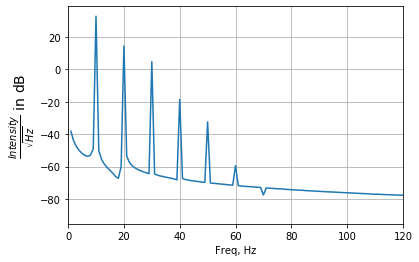

In [16]:
plt.plot(freq[1:], 10*np.log10(np.mean(Pxx[:,500:520], axis=1)[1:]))
plt.xlim(0,120)
plt.ylabel(r'$\frac{Intensity}{\sqrt{Hz}} $ in dB', fontsize=14)
plt.xlabel('Freq, Hz')
plt.grid()


#### second PZT harmonic is less than main one by 20 dB

#### 3.2. Phase changes (pair pulse [method](https://iopscience.iop.org/article/10.1088/1555-6611/aac714))

In [17]:
def extract_phase(E):
    X1 = (np.abs(E)**2)[0::4,:]
    X2 = (np.abs(E)**2)[1::4,:]
    X3 = (np.abs(E)**2)[2::4,:]
    X4 = (np.abs(E)**2)[3::4,:]

    phi = np.unwrap(np.arctan2(X1 - X3, X2 - X4), axis=0)
    phi -= phi[0]
    
    return phi

In [18]:
psi = np.array([0, np.pi/2, np.pi, 3*np.pi/2])
tau_delay = 500e-9
gauge_length = tau_delay * OTDR.c / OTDR.n0 / 2
index_gl = int(gauge_length / np.max(D_pzt) * len(D_pzt))

E = np.zeros((len(T_pzt), len(D_pzt)-index_gl), dtype=np.complex64)
A = np.array(W_pzt)
E = A[:,2:-index_gl] - A[:,index_gl:-2] * np.exp(1j * psi[np.arange(0,len(T_pzt),1) % 4])[:, None]

ph = extract_phase(E)

Text(0.5, 1.0, 'Phase waterfall')

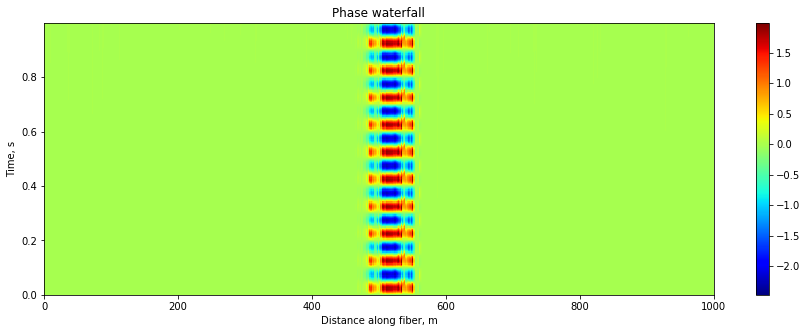

In [19]:
plt.figure(figsize=(15,5))
plt.imshow(ph, aspect='auto', origin='bottom', extent=[0, np.max(D_pzt), 0, np.max(T_pzt)], cmap='jet')
plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Time, s')
plt.title('Phase waterfall')

Text(0, 0.5, '$rad^2$')

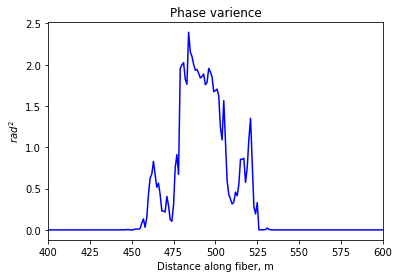

In [20]:
plt.title('Phase varience')
plt.plot(np.std(ph, axis=0)**2, c='blue')
plt.xlim(400,600)
plt.xlabel('Distance along fiber, m')
plt.ylabel('$rad^2$')

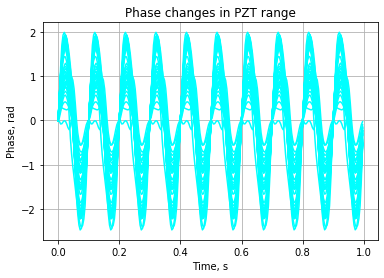

In [21]:
plt.title('Phase changes in PZT range')
plt.plot(T_pzt[::4], ph[:,470:520], c='cyan')
plt.xlabel('Time, s')
plt.ylabel('Phase, rad')
plt.grid()

In [22]:
freq, Pxx = signal.periodogram(ph, fs=1/(T_pzt[1]-T_pzt[0])/4, axis=0)

Text(0.5, 1.0, 'Phase waterfall')

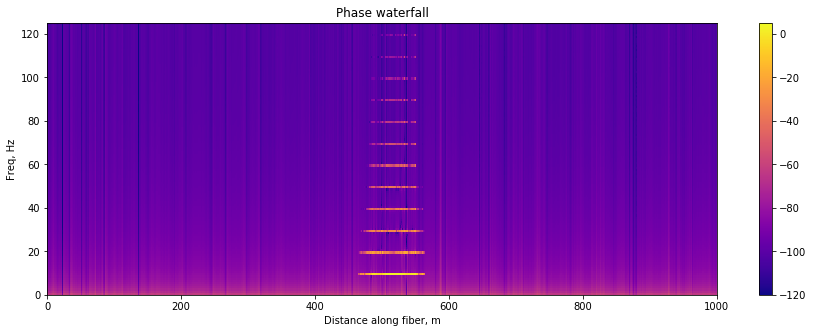

In [23]:
plt.figure(figsize=(15,5))
plt.imshow(10*np.log10(Pxx[1:]), aspect='auto', origin='bottom',
           extent=[0, np.max(D_pzt), 0, np.max(freq)], cmap='plasma', vmin=-120, vmax=5)
plt.colorbar()
plt.xlabel('Distance along fiber, m')
plt.ylabel('Freq, Hz')
plt.title('Phase waterfall')

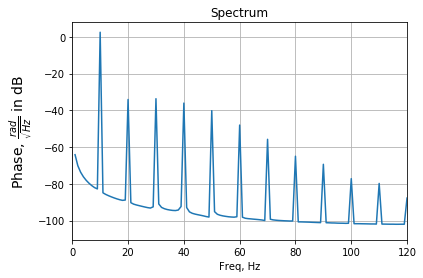

In [24]:
plt.plot(freq[1:], 10*np.log10(np.mean(Pxx[:,500-index_gl//2:520-index_gl//2], axis=1)[1:]))
plt.xlim(0,120)
plt.ylabel(r'Phase, $\frac{rad}{\sqrt{Hz}}$ in dB', fontsize=14)
plt.xlabel('Freq, Hz')
plt.title('Spectrum')
plt.grid()

#### second PZT harmonic is less than main one by 30 dB